In [1]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
import seaborn as sns
import matplotlib.pyplot as plt
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from scipy.stats import pearsonr
from minepy import MINE
from sklearn.metrics.pairwise import euclidean_distances

C:\Users\gigi_\anaconda3\envs\Bioinformatic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cell_line = 'HEK293'
window_size = 256
min_active_tpm_value_enhancers = 0.1
max_inactive_tpm_value_enhancers = 0.1

In [3]:
def knn_imputation(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [4]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [5]:
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [6]:
@Cache(
    cache_path="correlations/pearson/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_pearson(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Pearson correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

In [7]:
@Cache(
    cache_path="correlations/spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

In [8]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

# Data visualization for enhancers

In [9]:
region = 'enhancers'
X, y = active_enhancers_vs_inactive_enhancers(cell_line, 
                                              min_active_tpm_value=min_active_tpm_value_enhancers,
                                              max_inactive_tpm_value=max_inactive_tpm_value_enhancers)

Text(0.5, 1.0, 'Classes count in enhancers')

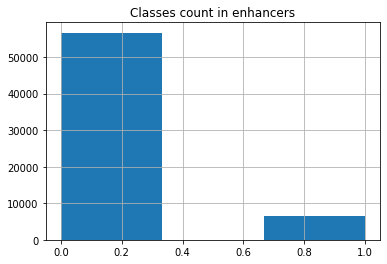

In [10]:
fig, ax = plt.subplots()
(y>min_active_tpm_value_enhancers).astype(int).hist(ax=ax, bins=3)
ax.set_title(f"Classes count in {region}")

In [11]:
# Rate features-samples of data
X.shape[0] / X.shape[1]

322.8826530612245

In [12]:
print("\n".join((
    f"Nan values report for GM12878 promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=1).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))

Nan values report for GM12878 promoters data:
In the document there are 1 NaN values out of 12403860 values.
The sample (row) with most values has 1 NaN values out of 196 values.
The feature (column) with most values has 1 NaN values out of 63285 values.


In [13]:
# Knn imputation
X = knn_imputation(X)

In [14]:
# Checking for constant features
drop_constant_features(X).shape != X.shape

False

In [15]:
# Data normalization
X = robust_zscoring(X)

In [16]:
p_value_threshold = 0.01
correlation_threshold = 0.05

# Pearson test
for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

The feature ZNF133 does not correlate in a statistically significant manner with the output.
The feature ZNF707 does not correlate in a statistically significant manner with the output.
The feature RBAK does not correlate in a statistically significant manner with the output.
The feature ZNF354C does not correlate in a statistically significant manner with the output.
The feature ZNF777 does not correlate in a statistically significant manner with the output.
The feature ZNF680 does not correlate in a statistically significant manner with the output.
The feature ZNF645 does not correlate in a statistically significant manner with the output.
The feature ZNF548 does not correlate in a statistically significant manner with the output.
The feature ZNF837 does not correlate in a statistically significant manner with the output.
The feature ZNF768 does not correlate in a statistically significant manner with the output.
The feature ZNF626 does not correlate in a statistically significant ma

In [17]:
# Pearson test
for feature_left in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_pearson(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
            
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Pearson test:  34%|███▎      | 66/196 [03:00<04:22,  2.02s/it]

The feature EGR2 is highly correlated with ZFHX2 (0.9092265782078754).


In [18]:
# Spearman test
for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Spearman test:   6%|▌         | 12/196 [00:00<00:03, 57.08it/s]

The feature ZNF23 does not correlate in a statistically significant manner with the output.


Running Spearman test:  16%|█▋        | 32/196 [00:00<00:02, 63.71it/s]

The feature ZNF530 does not correlate in a statistically significant manner with the output.
The feature ZNF433 does not correlate in a statistically significant manner with the output.
The feature ZNF777 does not correlate in a statistically significant manner with the output.


Running Spearman test:  27%|██▋       | 52/196 [00:00<00:02, 56.37it/s]

The feature ZBTB49 does not correlate in a statistically significant manner with the output.


Running Spearman test:  49%|████▉     | 96/196 [00:01<00:01, 58.63it/s]

The feature ZNF768 does not correlate in a statistically significant manner with the output.
The feature BCL6B does not correlate in a statistically significant manner with the output.
The feature ZNF791 does not correlate in a statistically significant manner with the output.


Running Spearman test:  58%|█████▊    | 114/196 [00:01<00:01, 58.19it/s]

The feature PRDM2 does not correlate in a statistically significant manner with the output.
The feature ZNF292 does not correlate in a statistically significant manner with the output.
The feature ZNF677 does not correlate in a statistically significant manner with the output.


Running Spearman test:  80%|████████  | 157/196 [00:02<00:00, 58.97it/s]

The feature ZNF404 does not correlate in a statistically significant manner with the output.
The feature ZSCAN26 does not correlate in a statistically significant manner with the output.
The feature ZNF426 does not correlate in a statistically significant manner with the output.
The feature ZNF155 does not correlate in a statistically significant manner with the output.


Running Spearman test:  94%|█████████▍| 185/196 [00:03<00:00, 59.87it/s]

The feature ZNF169 does not correlate in a statistically significant manner with the output.
The feature ZNF416 does not correlate in a statistically significant manner with the output.
The feature ZNF549 does not correlate in a statistically significant manner with the output.


The feature ZNF211 does not correlate in a statistically significant manner with the output.


In [19]:
# Spearman test
for feature_left in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_spearmanr(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

In [20]:
#INSERIRE NELLA LISTA LE FEATURES non legate all'output TROVATE PRIMA, Se sono state trovate!

for feature in tqdm(("ZNF133", "ZNF707", "RBAK", "ZNF354C", "ZNF777", "ZNF680", "ZNF645", "ZNF548", 
                     "ZNF837", "ZNF768", "ZNF626", "BCL6B", "ZNF791", "AEBP2", "ZNF529", "ZNF34", 
                     "ZNF157", "ZNF677", "ZNF488", "ZNF654", "ZNF624", "ZNF585B", "ZNF701", "ZNF302", 
                     "ZNF169", "H3K4me1", "ZNF266", "ZNF549", "GLI2", "ZNF23", "ZNF530", "ZNF433", 
                     "ZBTB49", "PRDM2", "ZNF292", "ZNF404", "ZSCAN26", "ZNF426", "ZNF155", "ZNF416", "ZNF211"), 
                    desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test:   2%|▏         | 1/41 [00:03<02:34,  3.85s/it]

The feature ZNF133 does not correlate in a statistically significant manner with the output.


Running MINE test:   5%|▍         | 2/41 [00:07<02:23,  3.67s/it]

The feature ZNF707 does not correlate in a statistically significant manner with the output.


Running MINE test:   7%|▋         | 3/41 [00:11<02:21,  3.72s/it]

The feature RBAK does not correlate in a statistically significant manner with the output.


Running MINE test:  10%|▉         | 4/41 [00:14<02:17,  3.72s/it]

The feature ZNF354C does not correlate in a statistically significant manner with the output.


Running MINE test:  12%|█▏        | 5/41 [00:18<02:14,  3.73s/it]

The feature ZNF777 does not correlate in a statistically significant manner with the output.


Running MINE test:  15%|█▍        | 6/41 [00:22<02:09,  3.69s/it]

The feature ZNF680 does not correlate in a statistically significant manner with the output.


Running MINE test:  17%|█▋        | 7/41 [00:26<02:06,  3.72s/it]

The feature ZNF645 does not correlate in a statistically significant manner with the output.


Running MINE test:  20%|█▉        | 8/41 [00:30<02:08,  3.90s/it]

The feature ZNF548 does not correlate in a statistically significant manner with the output.


Running MINE test:  22%|██▏       | 9/41 [00:33<02:01,  3.80s/it]

The feature ZNF837 does not correlate in a statistically significant manner with the output.


Running MINE test:  24%|██▍       | 10/41 [00:37<01:55,  3.73s/it]

The feature ZNF768 does not correlate in a statistically significant manner with the output.


Running MINE test:  27%|██▋       | 11/41 [00:41<01:51,  3.70s/it]

The feature ZNF626 does not correlate in a statistically significant manner with the output.


Running MINE test:  29%|██▉       | 12/41 [00:45<01:51,  3.85s/it]

The feature BCL6B does not correlate in a statistically significant manner with the output.


Running MINE test:  32%|███▏      | 13/41 [00:49<01:46,  3.81s/it]

The feature ZNF791 does not correlate in a statistically significant manner with the output.


Running MINE test:  34%|███▍      | 14/41 [00:52<01:39,  3.67s/it]

The feature AEBP2 does not correlate in a statistically significant manner with the output.


Running MINE test:  37%|███▋      | 15/41 [00:55<01:34,  3.63s/it]

The feature ZNF529 does not correlate in a statistically significant manner with the output.


Running MINE test:  39%|███▉      | 16/41 [00:59<01:32,  3.69s/it]

The feature ZNF34 does not correlate in a statistically significant manner with the output.


Running MINE test:  41%|████▏     | 17/41 [01:03<01:30,  3.78s/it]

The feature ZNF157 does not correlate in a statistically significant manner with the output.


Running MINE test:  44%|████▍     | 18/41 [01:07<01:29,  3.88s/it]

The feature ZNF677 does not correlate in a statistically significant manner with the output.


Running MINE test:  46%|████▋     | 19/41 [01:12<01:27,  4.00s/it]

The feature ZNF488 does not correlate in a statistically significant manner with the output.


Running MINE test:  49%|████▉     | 20/41 [01:18<01:36,  4.58s/it]

The feature ZNF654 does not correlate in a statistically significant manner with the output.


Running MINE test:  51%|█████     | 21/41 [01:21<01:25,  4.29s/it]

The feature ZNF624 does not correlate in a statistically significant manner with the output.


Running MINE test:  54%|█████▎    | 22/41 [01:25<01:18,  4.12s/it]

The feature ZNF585B does not correlate in a statistically significant manner with the output.


Running MINE test:  56%|█████▌    | 23/41 [01:29<01:12,  4.00s/it]

The feature ZNF701 does not correlate in a statistically significant manner with the output.


Running MINE test:  59%|█████▊    | 24/41 [01:32<01:07,  3.94s/it]

The feature ZNF302 does not correlate in a statistically significant manner with the output.


Running MINE test:  61%|██████    | 25/41 [01:37<01:04,  4.06s/it]

The feature ZNF169 does not correlate in a statistically significant manner with the output.


Running MINE test:  63%|██████▎   | 26/41 [01:43<01:10,  4.69s/it]

The feature H3K4me1 does not correlate in a statistically significant manner with the output.


Running MINE test:  66%|██████▌   | 27/41 [01:47<01:01,  4.40s/it]

The feature ZNF266 does not correlate in a statistically significant manner with the output.


Running MINE test:  68%|██████▊   | 28/41 [01:51<00:55,  4.24s/it]

The feature ZNF549 does not correlate in a statistically significant manner with the output.


Running MINE test:  71%|███████   | 29/41 [01:55<00:50,  4.21s/it]

The feature GLI2 does not correlate in a statistically significant manner with the output.


Running MINE test:  73%|███████▎  | 30/41 [01:58<00:44,  4.04s/it]

The feature ZNF23 does not correlate in a statistically significant manner with the output.


Running MINE test:  76%|███████▌  | 31/41 [02:02<00:39,  3.94s/it]

The feature ZNF530 does not correlate in a statistically significant manner with the output.


Running MINE test:  78%|███████▊  | 32/41 [02:06<00:34,  3.89s/it]

The feature ZNF433 does not correlate in a statistically significant manner with the output.


Running MINE test:  80%|████████  | 33/41 [02:10<00:30,  3.87s/it]

The feature ZBTB49 does not correlate in a statistically significant manner with the output.


Running MINE test:  83%|████████▎ | 34/41 [02:13<00:26,  3.81s/it]

The feature PRDM2 does not correlate in a statistically significant manner with the output.


Running MINE test:  85%|████████▌ | 35/41 [02:17<00:22,  3.79s/it]

The feature ZNF292 does not correlate in a statistically significant manner with the output.


Running MINE test:  88%|████████▊ | 36/41 [02:21<00:19,  3.83s/it]

The feature ZNF404 does not correlate in a statistically significant manner with the output.


Running MINE test:  90%|█████████ | 37/41 [02:25<00:15,  3.80s/it]

The feature ZSCAN26 does not correlate in a statistically significant manner with the output.


Running MINE test:  93%|█████████▎| 38/41 [02:28<00:11,  3.67s/it]

The feature ZNF426 does not correlate in a statistically significant manner with the output.


Running MINE test:  95%|█████████▌| 39/41 [02:32<00:07,  3.70s/it]

The feature ZNF155 does not correlate in a statistically significant manner with the output.


Running MINE test:  98%|█████████▊| 40/41 [02:36<00:03,  3.77s/it]

The feature ZNF416 does not correlate in a statistically significant manner with the output.


The feature ZNF211 does not correlate in a statistically significant manner with the output.


In [21]:
correlation_threshold = 0.95
scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = np.abs(correlation)
        scores.append((correlation, column, feature))
scores.sort(reverse=True)

Most correlated features from enhancers epigenomes


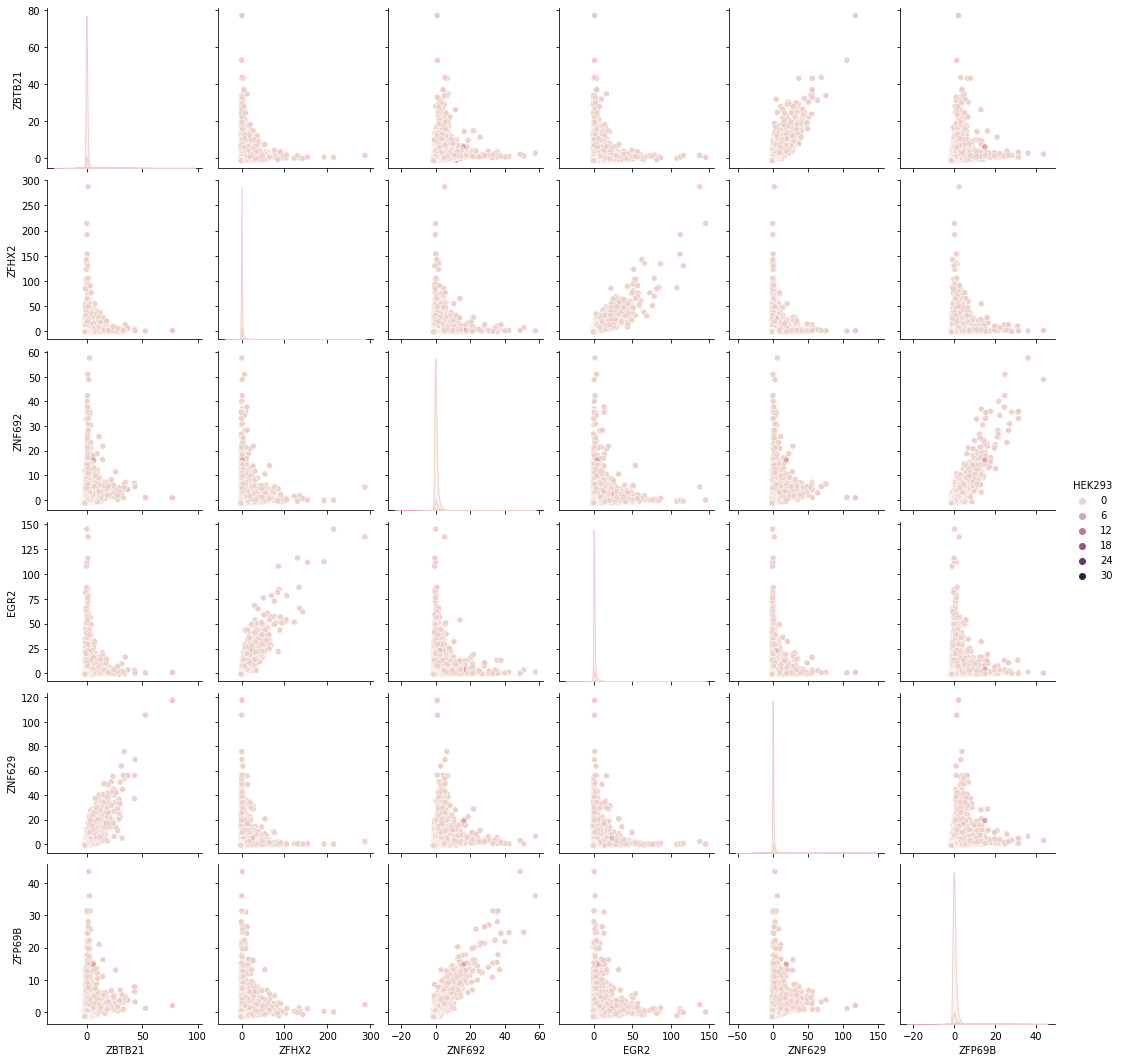

In [22]:
_, firsts, seconds = list(zip(*scores[:3]))
columns = list(set(firsts+seconds))
print(f"Most correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Least correlated features from enhancers epigenomes


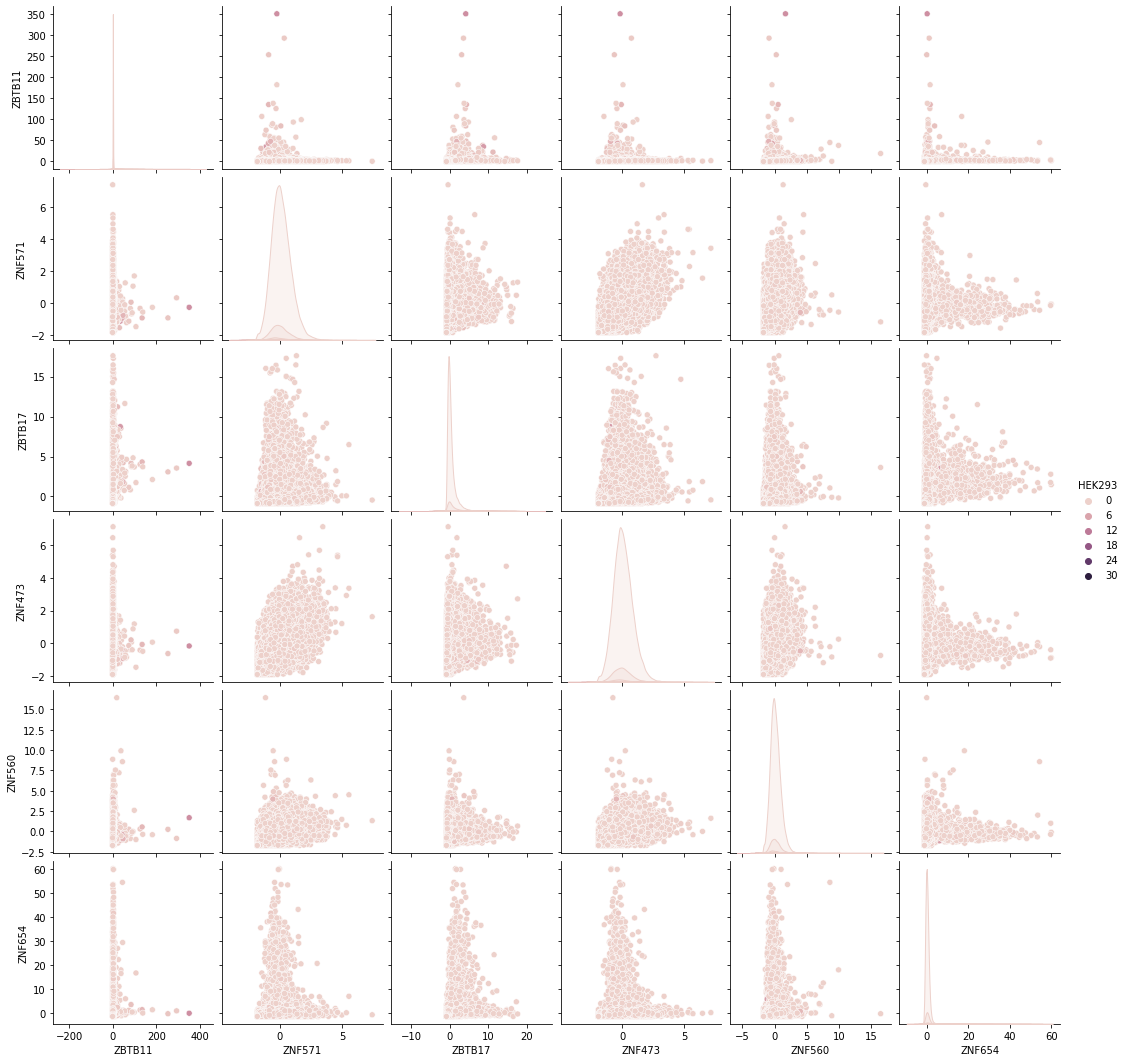

In [23]:
_, firsts, seconds = list(zip(*scores[-3:]))
columns = list(set(firsts+seconds))
print(f"Least correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Top 5 different features from enhancers.


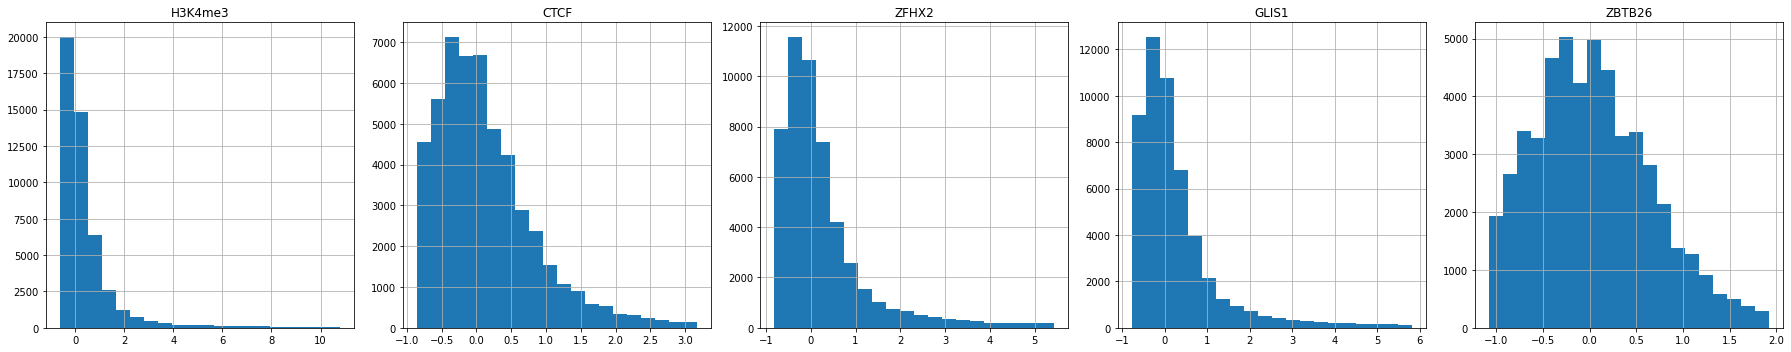

In [24]:
top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from {region}.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_x = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_x[cleared_y==0].hist(ax=axis, bins=20)
    cleared_x[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.tight_layout()
plt.show()

# Data visualization for Promoters

In [25]:
region = 'promoters'
X, y = active_promoters_vs_inactive_promoters(cell_line)

Text(0.5, 1.0, 'Classes count in promoters')

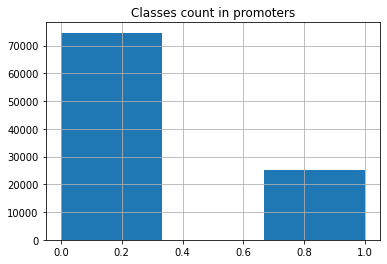

In [26]:
fig, ax = plt.subplots()
(y>1).astype(int).hist(ax=ax, bins=3)
ax.set_title(f"Classes count in {region}")

In [27]:
# Rate features-samples of data
X.shape[0] / X.shape[1]

509.5969387755102

In [28]:
print("\n".join((
    f"Nan values report for GM12878 promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=1).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))

Nan values report for GM12878 promoters data:
In the document there are 0 NaN values out of 19576676 values.
The sample (row) with most values has 0 NaN values out of 196 values.
The feature (column) with most values has 0 NaN values out of 99881 values.


In [29]:
# Knn imputation
X = knn_imputation(X)

In [30]:
# Checking for constant features
drop_constant_features(X).shape != X.shape

False

In [31]:
# Data normalization
X = robust_zscoring(X)

In [32]:
p_value_threshold = 0.01
correlation_threshold = 0.05

# Pearson test
for feature in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Pearson test:  29%|██▊       | 56/196 [00:00<00:00, 548.99it/s]

The feature ZNF510 does not correlate in a statistically significant manner with the output.
The feature RBAK does not correlate in a statistically significant manner with the output.
The feature ZNF350 does not correlate in a statistically significant manner with the output.
The feature ZNF423 does not correlate in a statistically significant manner with the output.
The feature ZNF645 does not correlate in a statistically significant manner with the output.
The feature ZNF398 does not correlate in a statistically significant manner with the output.
The feature ZNF626 does not correlate in a statistically significant manner with the output.
The feature BCL6B does not correlate in a statistically significant manner with the output.
The feature AEBP2 does not correlate in a statistically significant manner with the output.


The feature ZIC2 does not correlate in a statistically significant manner with the output.
The feature ZFP3 does not correlate in a statistically significant manner with the output.
The feature ZNF596 does not correlate in a statistically significant manner with the output.
The feature GFI1B does not correlate in a statistically significant manner with the output.
The feature ZNF488 does not correlate in a statistically significant manner with the output.
The feature ZNF792 does not correlate in a statistically significant manner with the output.
The feature ZNF624 does not correlate in a statistically significant manner with the output.
The feature ZNF426 does not correlate in a statistically significant manner with the output.
The feature ZNF302 does not correlate in a statistically significant manner with the output.
The feature ZNF148 does not correlate in a statistically significant manner with the output.
The feature ZNF16 does not correlate in a statistically significant manner 

In [33]:
# Pearson test
for feature_left in tqdm(X.columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_pearson(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
            
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

Running Pearson test:  34%|███▎      | 66/196 [03:19<04:57,  2.29s/it]

The feature EGR2 is highly correlated with ZFHX2 (0.9025409184224009).


Running Pearson test:  41%|████      | 80/196 [04:19<07:12,  3.73s/it]

The feature ZFP69B is highly correlated with ZNF692 (0.9251732720321488).


Running Pearson test:  76%|███████▌  | 148/196 [08:12<02:18,  2.89s/it]

The feature ZBTB21 is highly correlated with ZNF629 (0.9397677180843949).


In [34]:
# Spearman test
for feature in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[feature].values.flatten(), y.values.flatten())
    if p_value > p_value_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running Spearman test:  46%|████▌     | 90/196 [00:02<00:02, 36.05it/s]

The feature ZNF223 does not correlate in a statistically significant manner with the output.


Running Spearman test:  53%|█████▎    | 103/196 [00:02<00:02, 37.00it/s]

The feature AEBP2 does not correlate in a statistically significant manner with the output.


Running Spearman test:  84%|████████▎ | 164/196 [00:04<00:00, 44.76it/s]

The feature ZNF585B does not correlate in a statistically significant manner with the output.


Running Spearman test:  91%|█████████▏| 179/196 [00:04<00:00, 45.59it/s]

The feature ZNF302 does not correlate in a statistically significant manner with the output.


In [35]:
# Spearman test
for feature_left in tqdm(X.columns, desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
    for feature_right in X.columns:
        if feature_left >= feature_right:
            # Since the pearson correlation is simmetric, we do not need to check
            # for the entire squared matrix of features but the upper triangular one
            # is sufficient.
            continue
        pearson_result = compute_spearmanr(
            X,
            feature_left,
            feature_right,
            cell_line=cell_line,
            region=region
        )
        if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.90:
            correlation = pearson_result["correlation"]
            print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
            

In [36]:
#INSERIRE NELLA LISTA LE FEATURES non legate all'output TROVATE PRIMA, Se sono state trovate!

for feature in tqdm(("ZNF510", "RBAK", "ZNF350", "ZNF423", "ZNF645", "ZNF398", "ZNF626", "BCL6B",
                     "AEBP2", "ZIC2", "ZFP3", "ZNF596", "GFI1B", "ZNF488", "ZNF792", "ZNF624", 
                     "ZNF426", "ZNF302", "ZNF148", "ZNF16", "GLI2", "ZNF223", "ZNF585B"), 
                    desc=f"Running MINE test", dynamic_ncols=True, leave=False):
    mine = MINE()
    mine.compute_score(X[feature].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(f"The feature {feature} does not correlate in a statistically significant manner with the output.")

Running MINE test:   4%|▍         | 1/23 [00:30<11:19, 30.87s/it]

The feature ZNF510 does not correlate in a statistically significant manner with the output.


Running MINE test:   9%|▊         | 2/23 [01:01<10:47, 30.84s/it]

The feature RBAK does not correlate in a statistically significant manner with the output.


Running MINE test:  13%|█▎        | 3/23 [01:33<10:22, 31.12s/it]

The feature ZNF350 does not correlate in a statistically significant manner with the output.


Running MINE test:  17%|█▋        | 4/23 [02:21<12:00, 37.91s/it]

The feature ZNF423 does not correlate in a statistically significant manner with the output.


Running MINE test:  22%|██▏       | 5/23 [03:02<11:43, 39.10s/it]

The feature ZNF645 does not correlate in a statistically significant manner with the output.


Running MINE test:  30%|███       | 7/23 [05:05<13:05, 49.10s/it]

The feature ZNF626 does not correlate in a statistically significant manner with the output.


Running MINE test:  35%|███▍      | 8/23 [05:40<11:10, 44.67s/it]

The feature BCL6B does not correlate in a statistically significant manner with the output.


Running MINE test:  39%|███▉      | 9/23 [06:13<09:34, 41.01s/it]

The feature AEBP2 does not correlate in a statistically significant manner with the output.


Running MINE test:  48%|████▊     | 11/23 [07:59<09:09, 45.80s/it]

The feature ZFP3 does not correlate in a statistically significant manner with the output.


Running MINE test:  52%|█████▏    | 12/23 [08:38<08:01, 43.74s/it]

The feature ZNF596 does not correlate in a statistically significant manner with the output.


Running MINE test:  57%|█████▋    | 13/23 [09:14<06:54, 41.47s/it]

The feature GFI1B does not correlate in a statistically significant manner with the output.


Running MINE test:  61%|██████    | 14/23 [09:48<05:53, 39.27s/it]

The feature ZNF488 does not correlate in a statistically significant manner with the output.


Running MINE test:  65%|██████▌   | 15/23 [10:26<05:10, 38.81s/it]

The feature ZNF792 does not correlate in a statistically significant manner with the output.


Running MINE test:  70%|██████▉   | 16/23 [11:01<04:23, 37.60s/it]

The feature ZNF624 does not correlate in a statistically significant manner with the output.


Running MINE test:  74%|███████▍  | 17/23 [11:34<03:37, 36.21s/it]

The feature ZNF426 does not correlate in a statistically significant manner with the output.


Running MINE test:  78%|███████▊  | 18/23 [12:07<02:57, 35.45s/it]

The feature ZNF302 does not correlate in a statistically significant manner with the output.


Running MINE test:  83%|████████▎ | 19/23 [12:42<02:20, 35.09s/it]

The feature ZNF148 does not correlate in a statistically significant manner with the output.


Running MINE test:  87%|████████▋ | 20/23 [13:16<01:44, 34.80s/it]

The feature ZNF16 does not correlate in a statistically significant manner with the output.


Running MINE test:  91%|█████████▏| 21/23 [13:53<01:10, 35.49s/it]

The feature GLI2 does not correlate in a statistically significant manner with the output.


Running MINE test:  96%|█████████▌| 22/23 [14:29<00:35, 35.73s/it]

The feature ZNF223 does not correlate in a statistically significant manner with the output.


The feature ZNF585B does not correlate in a statistically significant manner with the output.


In [37]:
correlation_threshold = 0.95
scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = np.abs(correlation)
        scores.append((correlation, column, feature))
scores.sort(reverse=True)

Most correlated features from promoters epigenomes


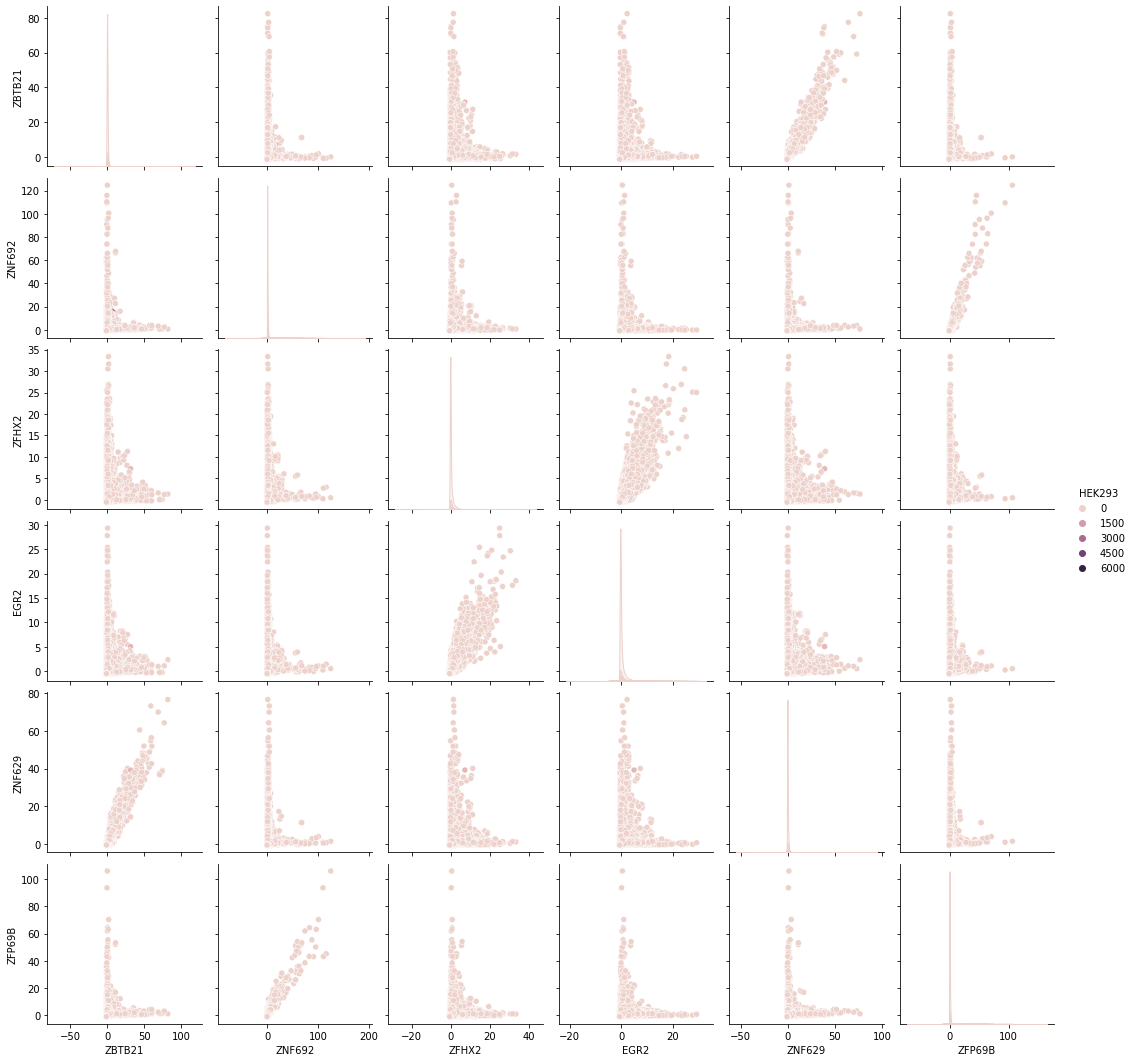

In [38]:
_, firsts, seconds = list(zip(*scores[:3]))
columns = list(set(firsts+seconds))
print(f"Most correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Least correlated features from promoters epigenomes


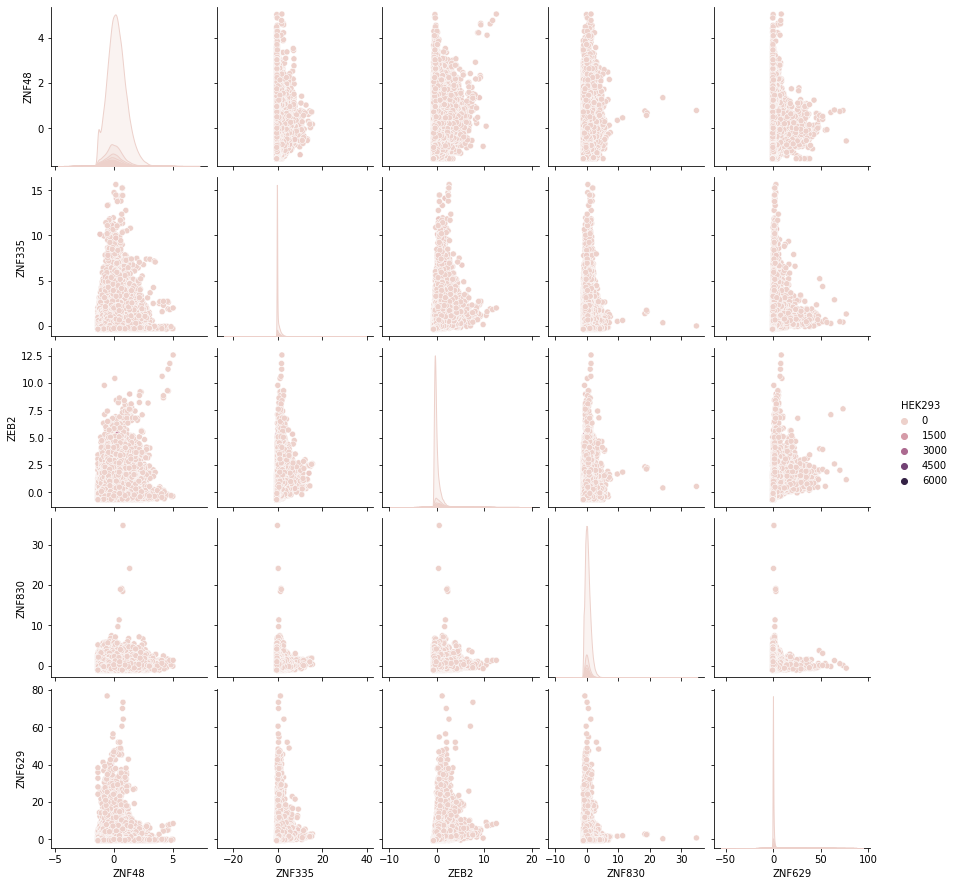

In [39]:
_, firsts, seconds = list(zip(*scores[-3:]))
columns = list(set(firsts+seconds))
print(f"Least correlated features from {region} epigenomes")
sns.pairplot(pd.concat([
    X[columns],
    y,
], axis=1), hue=y.columns[0])
plt.show()

Top 5 different features from promoters.


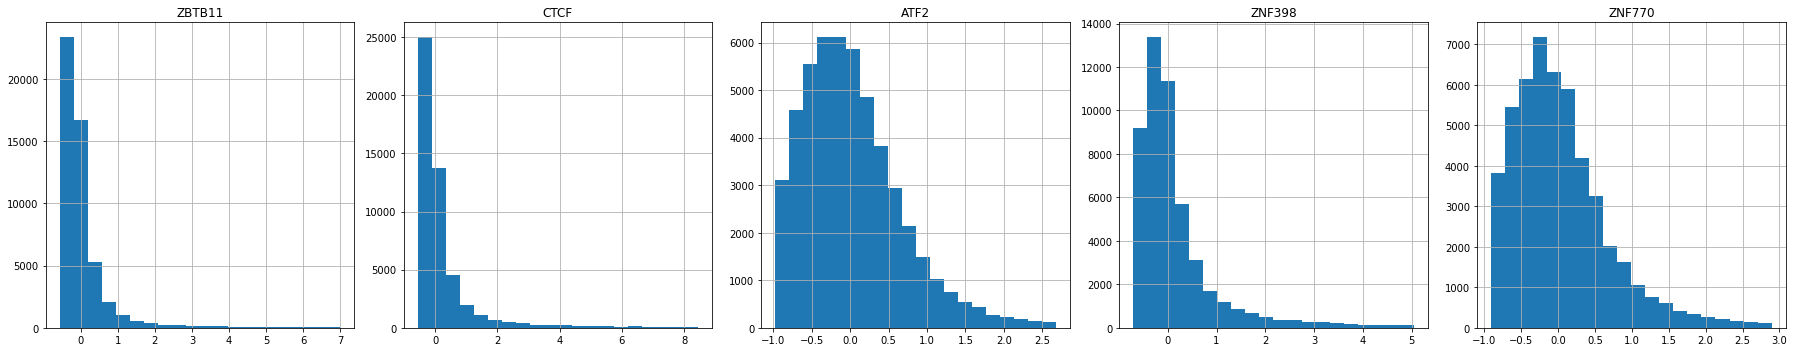

In [40]:
top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from {region}.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_x = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_x[cleared_y==0].hist(ax=axis, bins=20)
    cleared_x[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.tight_layout()
plt.show()